🗂️ Indexando imágenes...
📄 Archivos de prueba: 7558
🔍 Ejecutando inferencia...
7558/7558
📉 Generando matriz de confusión...


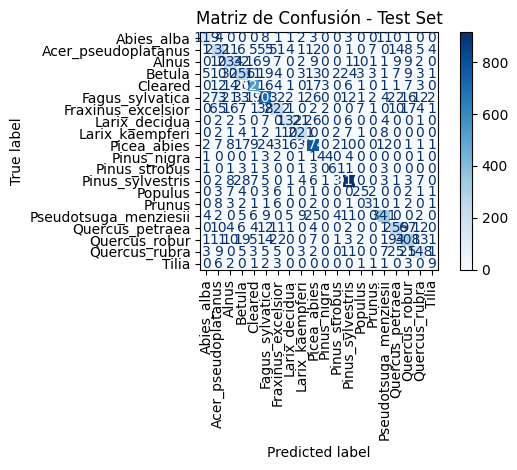


📋 Reporte de clasificación:
                       precision    recall  f1-score   support

           Abies_alba       0.86      0.78      0.82       153
  Acer_pseudoplatanus       0.49      0.54      0.52       426
                Alnus       0.61      0.66      0.64       352
               Betula       0.57      0.63      0.60       404
              Cleared       0.85      0.83      0.84       634
      Fagus_sylvatica       0.75      0.72      0.73       984
   Fraxinus_excelsior       0.58      0.56      0.57       394
        Larix_decidua       0.75      0.64      0.69       206
      Larix_kaempferi       0.81      0.85      0.83       260
          Picea_abies       0.83      0.87      0.85       890
          Pinus_nigra       0.88      0.76      0.81        58
        Pinus_strobus       0.81      0.78      0.80        78
     Pinus_sylvestris       0.90      0.92      0.91       995
              Populus       0.49      0.45      0.47        56
               Prunus    

In [1]:
import os
import json
from PIL import Image
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# -----------------------------
# Configuración
# -----------------------------
MODEL_PATH = "/kaggle/input/treetecmodels/efficientnetb0_tree_species.pth"
TXT_PATH = "/kaggle/input/treetecmodels/test_files.txt"
IMG_DIR = "/kaggle/input/treesattfg/Images/Images"
SPECIES_JSON = "/kaggle/input/treesattfg/species_list.json"

# -----------------------------
# Cargar lista de especies
# -----------------------------
with open(SPECIES_JSON, 'r') as f:
    species_list = json.load(f)

species_to_idx = {s: i for i, s in enumerate(species_list)}

# -----------------------------
# Extraer especie desde nombre de archivo
# -----------------------------
def extract_species(filename):
    basename = os.path.basename(filename).replace(".tif", "")
    parts = basename.split('_')
    species_parts = []
    for part in parts:
        if part.isdigit():
            break
        species_parts.append(part)
    species = "_".join(species_parts)
    species = species.replace("_spec.", "").replace(".", "")
    return species

# -----------------------------
# Transformaciones (EfficientNet-B0)
# -----------------------------
weights = EfficientNet_B0_Weights.DEFAULT
transform = weights.transforms()

# -----------------------------
# Cargar modelo EfficientNet-B0
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(species_list)

model = efficientnet_b0(weights=None)  # sin pesos preentrenados, usamos los tuyos
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# -----------------------------
# Crear índice de imágenes para acceso rápido
# -----------------------------
print("🗂️ Indexando imágenes...")
image_path_dict = {}
for root, _, files in os.walk(IMG_DIR):
    for file in files:
        if file.endswith(".tif"):
            image_path_dict[file] = os.path.join(root, file)

# -----------------------------
# Leer archivos de test
# -----------------------------
with open(TXT_PATH, 'r') as f:
    test_filenames = [line.strip() for line in f.readlines()]

print("📄 Archivos de prueba:", len(test_filenames))

# -----------------------------
# Inferencia
# -----------------------------
true_labels = []
pred_labels = []

print("🔍 Ejecutando inferencia...")
for i, filename in enumerate(test_filenames):
    print(f"{i+1}/{len(test_filenames)}", end="\r", flush=True)
    filepath = image_path_dict.get(filename)

    if filepath is None:
        print(f"⚠️ Archivo no encontrado: {filename}")
        continue

    true_species = extract_species(filename)
    if true_species not in species_to_idx:
        print(f"⚠️ Especie desconocida: {true_species} en archivo {filename}")
        continue

    true_idx = species_to_idx[true_species]

    image = Image.open(filepath).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        pred_idx = output.argmax(1).item()

    true_labels.append(true_idx)
    pred_labels.append(pred_idx)

# -----------------------------
# Matriz de confusión
# -----------------------------
print("\n📉 Generando matriz de confusión...")
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Matriz de Confusión - Test Set")
plt.tight_layout()
plt.show()

# -----------------------------
# Reporte de clasificación
# -----------------------------
print("\n📋 Reporte de clasificación:")
print(classification_report(true_labels, pred_labels, target_names=species_list, zero_division=0))
